# Introduction
 This Jupyter notebook will show the core basic functionality of the package.
 For details on function calls and class designs, inspection of the code is encouraged.
 
For some more advanced features, please refer to the `apps` directory.


### Agenda
The software is aimed to give a transparent and reliable grasp on the continuum model for the FEBID process. This flexible simulation package lets user change properties of a precursor, directly observe their influence on the resulting precursor coverage and growth rate profiles, run series of virtual experiments (as well in parallel), save them and open later for analysis. The simulation is based on a steady-state solution of the *Reaction-Diffusion Equation* assuming stationary exposure. 
Package includes a simple *Secondary electron* flux estimator and a feature to set beam profile shape.
For a better understanding of the concepts and variable naming, refer to corresponding articles:
1. Continuum models of focused electron beam induced processing, Beilstein J. Nanotechnol. 2015, 6, 1518–1540.
2. Lateral resolution in focused electron beam-induced deposition: scaling laws for pulsed and static exposure, Appl. Phys. A 2014, 117, 1715–1726.
3. Determination of the surface diffusion coefficient and the residence time of adsorbates via local focused electron beam induced chemical vapour deposition - Journal of Nanoscience and Nanotechnology, 2011, 11(9), 8074-8078

### Setting up
The very first thing is to make sure all the packages from `requirements.txt` are installed.

You might need to change the configuration of PyOpenCl if you intend to use GPU.

### 1. Basic use case

The core functionality of the package is reproducing a single independent *Experiment*, that based on precursor material and beam settings results in a growth rate profile. An *Experiment* is set up with a number of parameters, that are needed to solve the *Reaction-Diffusion Equation (RDE)*, that includes precursor parameters, beam parameters and grid. 

The package uses variable naming conventions that are consistent with the literature. These attributes are available in the Experiment1D class:

Precursor parameters:
- *n0* - precursor surface density
- *F* - precursor flux
- *s* - sticking coefficient
- *V* - volume deposited from a single precursor molecule
- *tau* - residence time of the precursor molecule
- *D* - surface diffusion coefficient
- *sigma* - dissociation cross-section

Beam settings:
- *f0* - central beam flux
- *fwhm* - full width at half maximum of the beam profile
- *st_dev* - standard deviation of the Gaussian
- *order* – order of the Super-Gaussian function
- *step* - grid resolution

Growth rate profile features:
- *R* - growth rate profile
- *R_max* - maximum growth rate
- *R_0* - growth rate at the center of the beam
- *fwhm_d* - full width at half maximum of the growth rate profile
- *r_max* - position of the maximum growth rate
- *r_max_n* - position of the maximum growth rate normalized to the beam width 
- *R_ind* - relative indent depth

- *f* - secondary electron flux profile
- *n* - precursor coverage profile

Process parameters:
- *p_o* - diffusive replenishment
- *tau_r* - depletion
- *kd* - depletion rate (at beam center)
- *kr* - replenishment rate (without irradiation)
- *nd* – depleted precursor coverage (at beam center)
- *nr* – replenished precursor coverage (without irradiation)
- *tau_in* - effective residence time at the beam center
- *tau_out* - effective residence time outside the beam (without irradiation)
- *p_in* - precursor molecule diffusion path at the beam center
- *p_out* - precursor molecule diffusion path outside the beam (without irradiation)
- *p_i* - normalized precursor molecule diff. path in the center of the beam
- *phi1* - resolution parameter: deposit size relative to beam size without surface diffusion
- *phi2* - resolution parameter: deposit size relative to beam size with surface diffusion

These attributes can be checked for further info and units in the corresponding classes in the `backend` directory.

In [ ]:
from backend.processclass import Experiment1D

pr = Experiment1D()

# Precursor
pr.n0 = 2.7  # 1/nm^2
pr.F = 730.0  # 1/nm^2/s
pr.s = 1.0
pr.V = 0.05  # nm^3
pr.tau = 700e-6  # s
pr.D = 1e6  # nm^2/s
pr.sigma = 0.02  # nm^2
# Beam
pr.f0 = 1.0e7  # 1/nm^2/s
pr.fwhm = 200  # nm
# Grid
pr.step = 0.1  # nm - grid resolution
# The grid size is determined automatically based on the parameters

After all the necessary parameters are set, the solution for the steady state can be found:

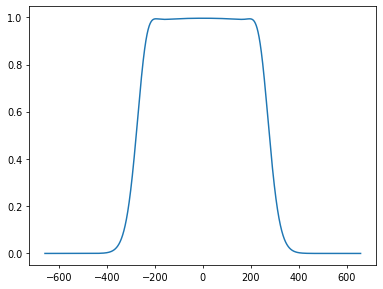

In [9]:
pr.solve_steady_state()
pr.plot('R', dpi=70)

Plotted graph is the dimensionless growth rate profile or the growth rate divided by the sticking coefficient *s*, surface precursor flux *F* and volume deposited from a single precursor molecule *V*.

By changing the parameters the user can directly observe their influence on the growth rate profile. In order to get a better grasp on how it works, the user is encouraged to launch an interactive app
that has the above example wrapped into user interface.
Launch `apps/growth_rate_profile.py`


### 2. Analysing profiles

After the solution has been obtained, the normalised growth rate profile can be analyzed by looking at the profile features:

In [ ]:
print(pr.R_max) # maximum growth profile height
print(pr.fwhm_d)  # the width of the growth profile

If the growth profile exhibits an indented shape, indent depth and outer peak position can be examined:

In [6]:
print(pr.r_max) # position of the highest point of the profile
print(pr.R_ind) # relative indent or (R_max-R_0)/R_max

6.194037738858435
1.7870006431783354
1.3590072058709197
0.23950379589466309


### 3. Running series of experiments

In order to examine a cross-correlation between precursor parameters, process parameters and growth rate profile features, a series of *Experiments* with a varied parameter are required.

A class *ExperimentSeries2D* enables storing and basic analysis of several *Experiments*.


An example of a script running a series of experiments may look like this:

In [11]:
import numpy as np
from backend.experimentsclass import loop_param
# First it is essential to create a simple Experiment and set initial parameters
# This is done exactly like it was shown above

# Next a varied variable name and values should be defined
name = 'D'
vals = np.arange(1e4, 7e5, 5e4)

# Now, series of experiments can be run by consequently varying the surface diffusion parameter.
# Here, a ready-to-go function is used, that iterates over the values, sets them in the Experiment instance, solves RDE and collects all the Experiments
exps = loop_param(name, vals, pr)

Just like a single *Experiment*, *ExperimentSeries* has a basic plotting feature:

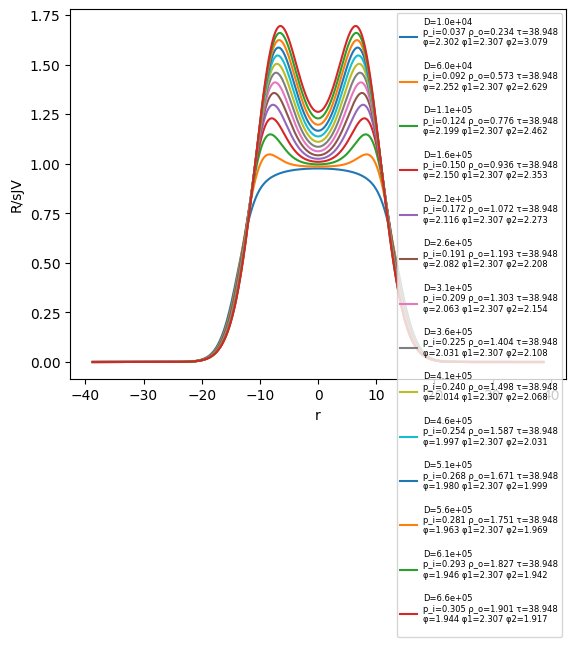

In [12]:
exps.plot('R')

After simulations of the experiments are finished, it is possible to extract a parameter from each experiment in a form of an array:

In [13]:
diff_coeff = exps.get_attr('D')
print(diff_coeff)

[ 10000.  60000. 110000. 160000. 210000. 260000. 310000. 360000. 410000.
 460000. 510000. 560000. 610000. 660000.]


The class also enables extraction of basic profile features of the normalized growth rate like peak height and indented profile features like peak distance from the center and relative indent depth:

In [23]:
fwhm = exps.get_attr('fwhm_d')
r_max = exps.get_attr('r_max')
R_ind = exps.get_attr('R_ind')
print(r_max)

[5.78081375e-06 8.33820199e+00 8.19630774e+00 7.96326580e+00
 7.74478674e+00 7.54832039e+00 7.37151681e+00 7.21113386e+00
 7.06427706e+00 6.92869589e+00 6.80249739e+00 6.68419552e+00
 6.57258361e+00 6.46667407e+00]


Any of the parameters including these profile features can then be plotted against the varied (scanned) parameter or against any of the process parameters:

C:\Users\sandr\PycharmProjects\febid_2d\program.py:84: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  line = ax.scatter(x, y, c=color, cmap='magma')


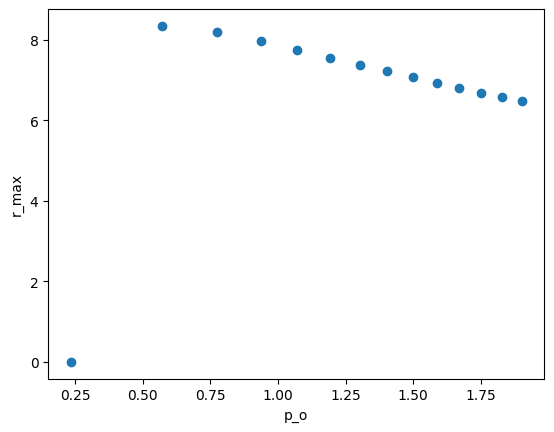

In [15]:
# Here, a prepared function is used for plotting:
from backend.plotting import plot_from_exps

plot_from_exps(exps, 'p_o', 'r_max')